In [1]:
%reset
%matplotlib inline
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean
import warnings; warnings.filterwarnings('ignore')
print('ready')

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
ready


In [2]:
grid_data=xr.open_zarr("/scratch/ag7531/shareElizabeth/grid_dataforeli")
uv_data  =xr.open_zarr("/scratch/ag7531/shareElizabeth/uv_dataforeli")

In [3]:
#Uncomment to print the uv_data information:
#uv_data 

In [5]:
#Uncomment to print the grid_data information:
#grid_data

We have read in the grid data (dataset grid_data) and the surface velocity data (dataset uv_data) above. The velocity variables are **usurf(time, yu_ocean, xu_ocean)** and **vsurf(time, yu_ocean, xu_ocean)** defined at points **(xu_ocean, yu_ocean)** which can be found in the 'Coordinates' of the velocity data or grid data. The values given by **xu_ocean** and **yu_ocean** (1D arrays) are identical between the two files. We read in the latitude and longitude points from the grid_data file, these variables are **geolat_c(yu_ocean, xu_ocean)** and **geolon_c(yu_ocean, xu_ocean)**. The latitude and longitude we use are the values corresponding to the velocity locations on the B-grid cells. We also read in the zonal grid spacing **dxt** and meridional grid spacing **dyt**; these spacings are defined at tracer points.

In [6]:
##Reading in surface velocity data and the (xu_ocean, yu_ocean) velocity points:
usurf = uv_data.usurf.values[-1,:,:] #Reading in the last time index
vsurf = uv_data.vsurf.values[-1,:,:] #Reading in the last time index
yu_ocean = grid_data.yu_ocean.values 
xu_ocean = grid_data.xu_ocean.values

##Reading in latitude and longitude at velocity points:
geolat = grid_data.geolat_c.values
geolon = grid_data.geolon_c.values
##Reading in the grid spacing for thickness points:
dyt = grid_data.dyt.values
dxt = grid_data.dxt.values
dyu = grid_data.dyu.values
dxu = grid_data.dxu.values
dau = grid_data.area_u.values
dat = grid_data.area_t.values
print(usurf.shape)
print('finished')

(2700, 3600)
finished


In [7]:
usurf_rounded = np.around(usurf,decimals=4)
vsurf_rounded = np.around(vsurf,decimals=4)
print('done')

done


### Plotting the unfiltered u velocity (note this takes several minutes to plot on the PlateCarree projection)

in progress
almost done


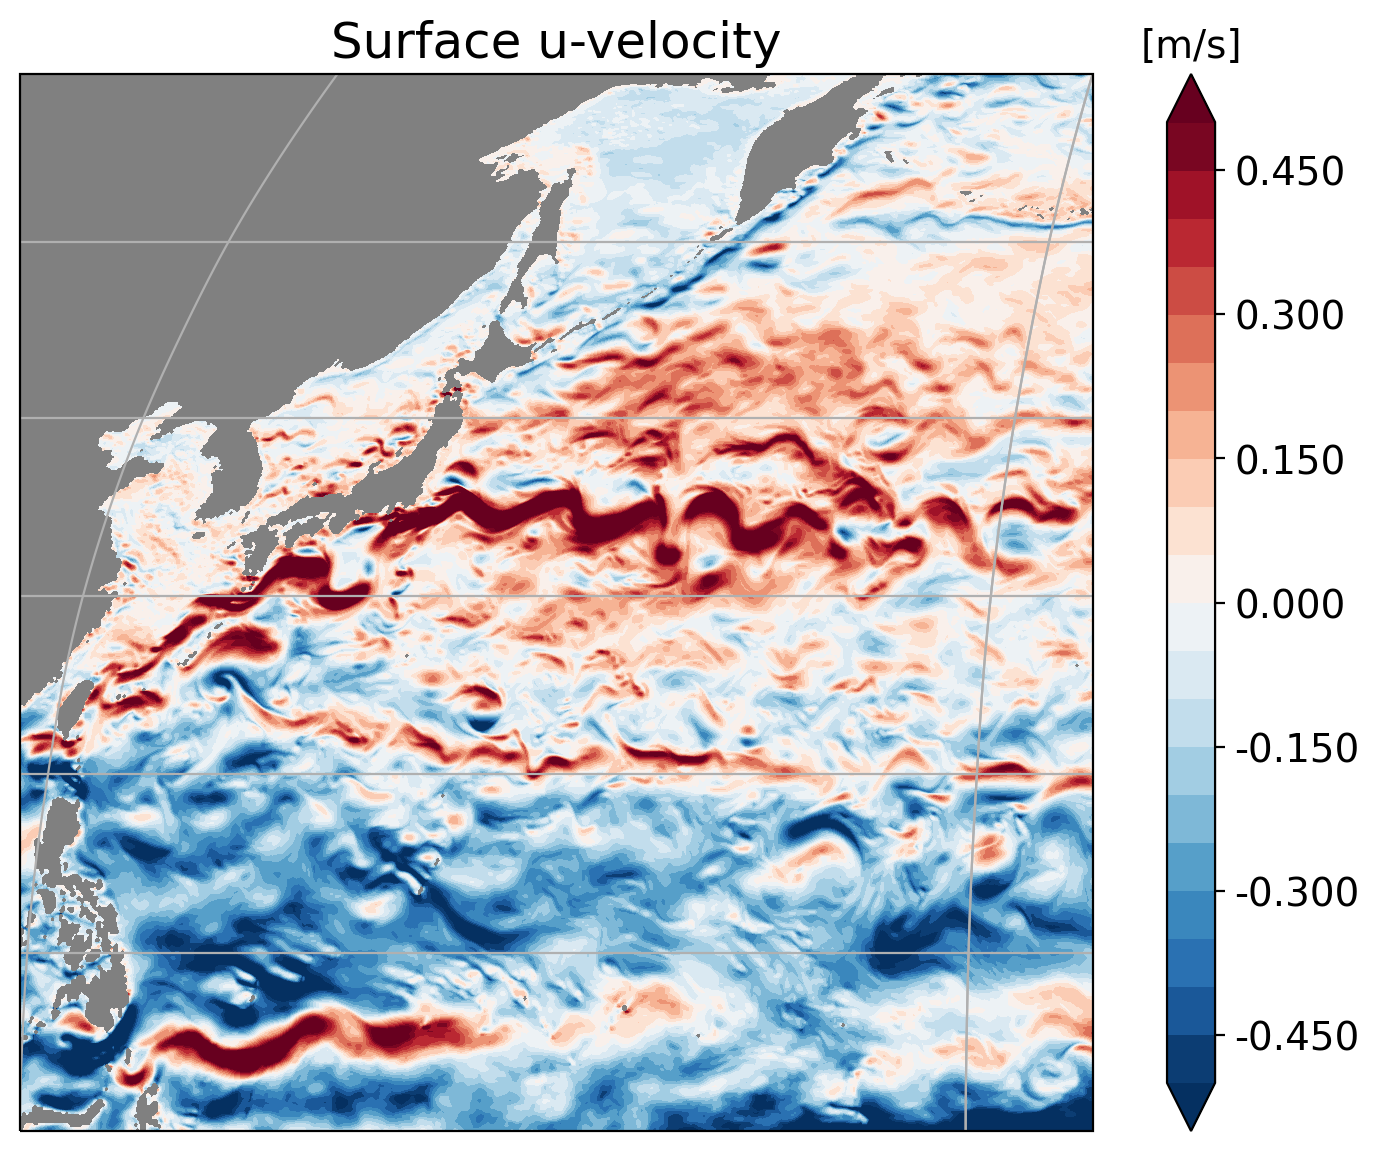

In [12]:
fig = plt.figure(figsize=(12, 7), dpi= 200, facecolor='w', edgecolor='k')
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-140))
ax.set_extent([-240, -180, 0, 60],ccrs.PlateCarree())

levels = np.linspace(-.5, .5, 21)
plt.pcolormesh(geolon, geolat,np.ones(dxu.shape),transform=ccrs.PlateCarree(),cmap='gray',vmin=0,vmax=2);
print('in progress')
plt.contourf(geolon,geolat,usurf_rounded,levels=levels,transform=ccrs.PlateCarree(),cmap='RdBu_r',extend='both');
print('almost done')

cbar=plt.colorbar(fraction=0.046, pad=0.04,format='%.3f'); cbar.ax.tick_params(labelsize=14);
cbar.ax.set_title('[m/s]', fontsize=14)
gl=ax.gridlines(crs=ccrs.PlateCarree())
plt.title('Surface u-velocity',fontsize=18)
plt.show()



### Plotting the unfiltered v velocity (note this takes several minutes to plot on the PlateCarree projection)

in progress
almost done


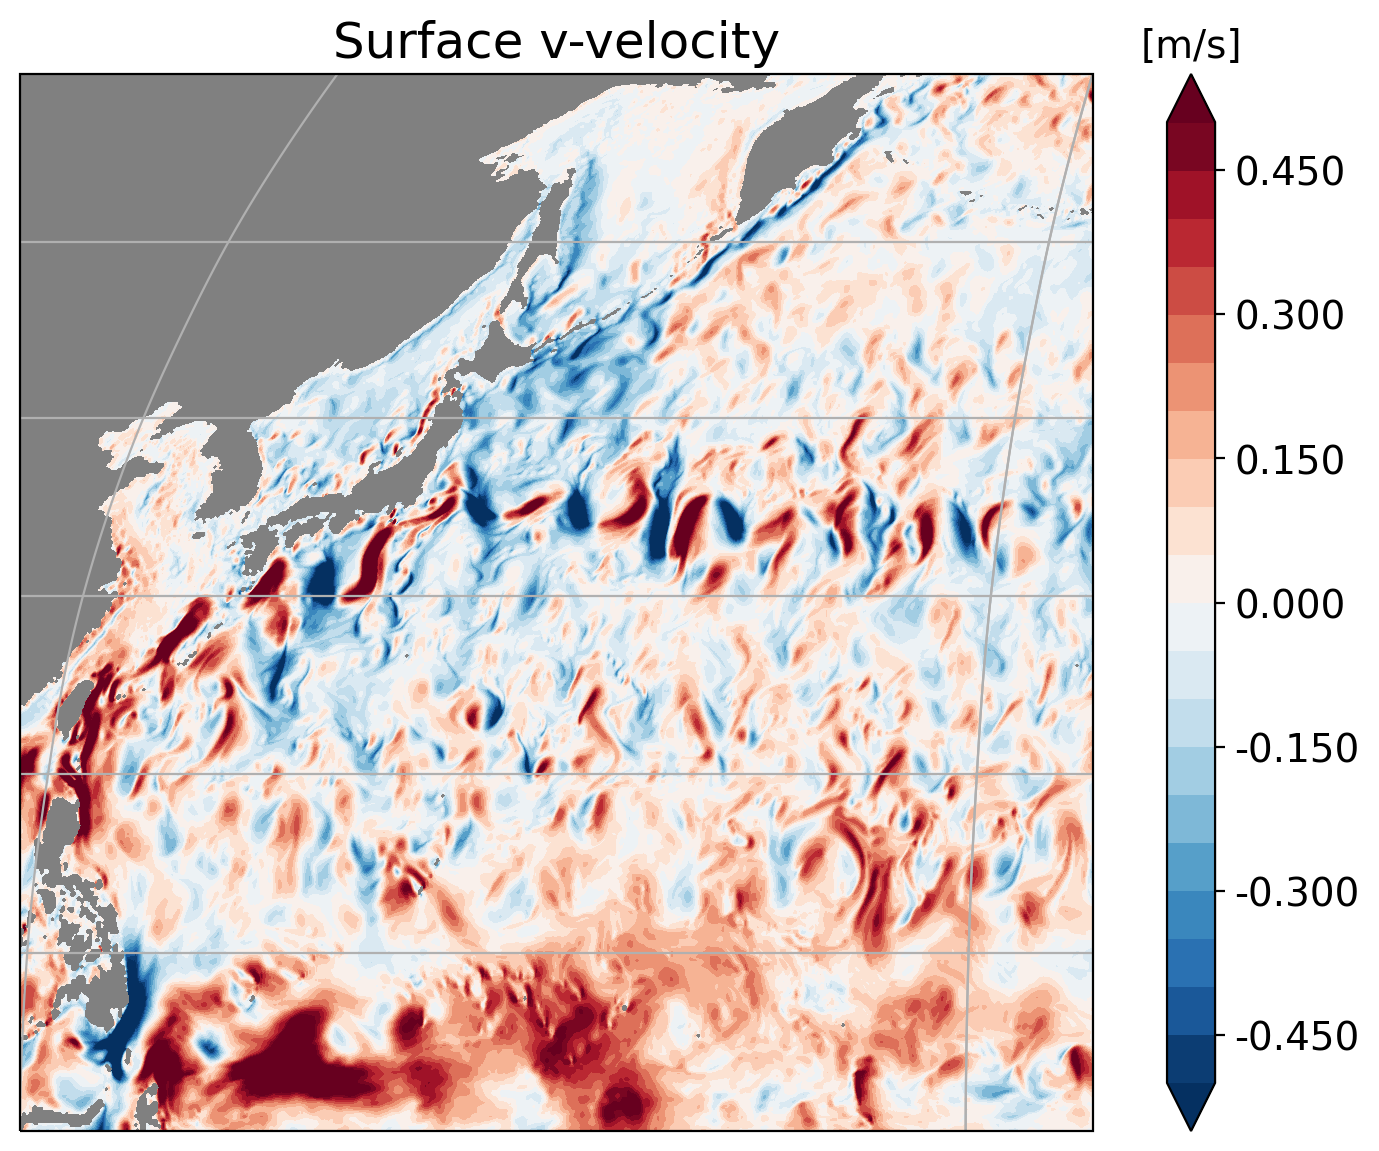

In [13]:
fig = plt.figure(figsize=(12, 7), dpi= 200, facecolor='w', edgecolor='k')
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-140))
ax.set_extent([-240, -180, 0, 60],ccrs.PlateCarree())

levels = np.linspace(-0.5, 0.5, 21)
plt.pcolormesh(geolon, geolat,np.ones(dxu.shape),transform=ccrs.PlateCarree(),cmap='gray',vmin=0,vmax=2);
print('in progress')
plt.contourf(geolon,geolat,vsurf_rounded,levels=levels,transform=ccrs.PlateCarree(),cmap='RdBu_r',extend='both');
print('almost done')

cbar=plt.colorbar(fraction=0.046, pad=0.04,format='%.3f'); cbar.ax.tick_params(labelsize=14);
cbar.ax.set_title('[m/s]', fontsize=14)
gl=ax.gridlines(crs=ccrs.PlateCarree())
plt.title('Surface v-velocity',fontsize=18)
plt.show()

### Defining the Laplacian filter on a t-cell in MOM5 (B-grid)
We define our Laplacian filter based on the LAP_T operator in MOM5, for computing the lateral Laplacian of T-cell fields weighted by a diffusivity. See original code here:
https://github.com/mom-ocean/MOM5/blob/master/src/mom5/ocean_core/ocean_operators.F90

For grid variables see code here:
https://github.com/mom-ocean/MOM5/blob/master/src/mom5/ocean_core/ocean_grids.F90

The code involves the following steps.
First, we loop over i,j to solve for the first derivatives fx and fy:

    fx(i,j) = 0.5*(mix(i,j)+mix(i+1,j))*((a(i+1,j)-a(i,j))*Grd%dxter(i,j))*fmx_tmask(i,j,k)
    fy(i,j) = 0.5*(mix(i,j)+mix(i,j+1))*((a(i,j+1)-a(i,j))*Grd%dytnr(i,j))*fmy_tmask(i,j,k)
    
Here, **mix** is the mixing coefficient assumed to be centred on the T-cell (it is averaged to compute its value on the i-face and j-face for computing fluxes). **a** is the field to which the Laplacian is applied. **Grd%dxter** is the reciprocal of **dxte** which is distance to adjacent t cell to the east. **Grd%dytnr** is the reciprocal of **dytn** which is distance to adjacent t cell to the north.

Second, we again loop over i,j to compute the Laplacian:

    chg = (Grd%dyte(i,j)*fx(i,j) - Grd%dyte(i-1,j)*fx(i-1,j))*Grd%datr(i,j) &
          + (Grd%dxtn(i,j)*fy(i,j) - Grd%dxtn(i,j-1)*fy(i,j-1))*Grd%datr(i,j)
    LAP_T(i,j) = Grd%tmask(i,j,k)*chg

Here, **Grd%dyte** is height of eastern face of t cell, **Grd%datr** is the reciprocal of **dat** which is an area computed by multiplying **dxt** and **dyt** (the widths and heights of a t-cell, respectively). **Grd%dxtn** is width of northern face of t cell.

# Our implementation of the MOM5 Laplacian (B-grid) for tracer fields

We assume that our field is defined on tracer points.
First, we loop over i,j to solve for the first derivatives fx and fy.

    fx(i,j) = (a(i+1,j)-a(i,j))*1/dxte(i,j)
    Use that dxte(i,j)=0.5*(dxu(i,j)+dxu(i,j-1))
    fy(i,j) = (a(i,j+1)-a(i,j))*1/dytn(i,j)
    Use that dytn(i,j)=0.5*(dyu(i,j)+dyu(i-1,j))
    
#### So the first derivatives become:

    fx(i,j) = (a(i+1,j)-a(i,j))*2/(dxu(i,j)+dxu(i,j-1))
    fy(i,j) = (a(i,j+1)-a(i,j))*2/(dyu(i,j)+dyu(i-1,j))
    
Second, we again loop over i,j to compute the second derivatives:

    chg = (dyte(i,j)*fx(i,j) - dyte(i-1,j)*fx(i-1,j))*1/(dat(i,j) &
        + (dxtn(i,j)*fy(i,j) - dxtn(i,j-1)*fy(i,j-1))*1/(dat(i,j)
    Approximate dyte(i,j)~0.5*(dyt(i,j)+dyt(i+1,j)) and dxtn(i,j)~0.5*(dxt(i,j)+dxt(i,j+1))

#### So the Laplacian becomes:
    chg = ( 0.5*(dyt(i,j)+dyt(i+1,j))*fx(i,j) - 0.5*(dyt(i-1,j)+dyt(i,j))*fx(i-1,j) )*1/dat(i,j) &
        + ( 0.5*(dxt(i,j)+dxt(i,j+1))*fy(i,j) - 0.5*(dxt(i,j-1)+dxt(i,j))*fy(i,j-1) )*1/dat(i,j)
    LAP_T(i,j) = chg
    
For questions related to the grid and derivative definitions see Figure 9.7:
https://mom-ocean.github.io/assets/pdfs/MOM5_manual.pdf

In [8]:
def MOM5_Laplacian_t(a, dxt, dyt, dxu, dyu, dat):
    #a is the field DEFINED ON T-CELL for which Laplacian is being computed
    #dxt is x-direction grid width for a t-cell
    #dyt is y-direction grid width for a t-cell
    #dxu is x-direction grid width for a u-cell
    #dyu is y-direction grid width for a u-cell
    #dat is the area of a t-cell
    
    #Initialize empty arrays for fx, fy (first derivatives), and LAP_T (final Laplacian result)
    fx = np.empty(a.shape)
    fy = np.empty(a.shape)
    LAP_T = np.empty(a.shape)
    
    for i in range(1,a.shape[0]-1):
        for j in range(1,a.shape[1]-1):
            fx[i,j]=(a[i+1,j]-a[i,j])*2.0/(dxu[i,j]+dxu[i,j-1])              
    print('Computed fx')
    for i in range(1,a.shape[0]-1):
        for j in range(1,a.shape[1]-1):
            fy[i,j]=(a[i,j+1]-a[i,j])*2.0/(dyu[i,j]+dyu[i-1,j]) 
    print('Computed fy') 
    for i in range(1,a.shape[0]-1):
        for j in range(1,a.shape[1]-1):

            LAP_T[i,j]=( 0.5*(dyt[i,j]+dyt[i+1,j])*fx[i,j] - 0.5*(dyt[i-1,j]+dyt[i,j])*fx[i-1,j] )*1/dat[i,j] \
            + ( 0.5*(dxt[i,j]+dxt[i,j+1])*fy[i,j] - 0.5*(dxt[i,j-1]+dxt[i,j])*fy[i,j-1] )*1/dat[i,j]

    print('Computed LAP_T')

    return LAP_T


# Our implementation of the MOM5 Laplacian (B-grid) for velocity fields
The form of the Laplacian shown above is for fields defined on t cells. Here we transpose the above operations for a field defined on velocity cells. 

First, we loop over i,j to solve for the first derivatives fx and fy.

    fx(i,j) = (a(i+1,j)-a(i,j))*1/dxue(i,j)
    Use that dxue(i,j)=0.5*(dxt(i+1,j)+dxt(i+1,j+1))
    fy(i,j) = (a(i,j+1)-a(i,j))*1/dyun(i,j)
    Use that dyun(i,j)=0.5*(dyt(i,j+1)+dyt(i+1,j+1))
    
#### So the first derivatives become:

    fx(i,j) = (a(i+1,j)-a(i,j))*2/(dxt(i+1,j)+dxt(i+1,j+1))
    fy(i,j) = (a(i,j+1)-a(i,j))*2/(dyt(i,j+1)+dyt(i+1,j+1)
    
Second, we again loop over i,j to compute the second derivatives:

    chg = (dyue(i,j)*fx(i,j) - dyue(i-1,j)*fx(i-1,j))*1/(dau(i,j) &
        + (dxun(i,j)*fy(i,j) - dxun(i,j-1)*fy(i,j-1))*1/(dau(i,j)
    Approximate dyue(i,j)~0.5*(dyu(i,j)+dyu(i+1,j)) and dxun(i,j)~0.5*(dxu(i,j)+dxu(i,j+1))

#### So the Laplacian becomes:
    chg = ( 0.5*(dyu(i,j)+dyu(i+1,j))*fx(i,j) - 0.5*(dyu(i-1,j)+dyu(i,j))*fx(i-1,j) )*1/dau(i,j) &
        + ( 0.5*(dxu(i,j)+dxu(i,j+1))*fy(i,j) - 0.5*(dxu(i,j-1)+dxu(i,j))*fy(i,j-1) )*1/dau(i,j)
    LAP_U(i,j) = chg
    
For questions related to the grid and derivative definitions see Figure 9.7:
https://mom-ocean.github.io/assets/pdfs/MOM5_manual.pdf

In [9]:
# Checking inputs
print(usurf.shape)
print(vsurf.shape)
print(dxt.shape)
print(dyt.shape)

(2700, 3600)
(2700, 3600)
(2700, 3600)
(2700, 3600)


In [10]:
def MOM5_Laplacian_u(a, dxt, dyt, dxu, dyu, dau):
    #a is the field DEFINED ON U-CELL for which Laplacian is being computed
    #dxt is x-direction grid width for a t-cell
    #dyt is y-direction grid width for a t-cell
    #dxu is x-direction grid width for a u-cell
    #dyu is y-direction grid width for a u-cell
    #dau is the area of a u-cell
    
    #Initialize empty arrays for fx, fy (first derivatives), and LAP_U (final Laplacian result)
    fx = np.empty(a.shape)
    fy = np.empty(a.shape)
    LAP_U = np.empty(a.shape)
    
    for i in range(a.shape[0]-1):
        for j in range(a.shape[1]-1):
            fx[i,j]=(a[i+1,j]-a[i,j])*2.0/(dxt[i+1,j]+dxt[i+1,j+1])              
    print('Computed fx')
    for i in range(a.shape[0]-1):
        for j in range(a.shape[1]-1):
            fy[i,j]=(a[i,j+1]-a[i,j])*2.0/(dyt[i,j+1]+dyt[i+1,j+1]) 
    print('Computed fy') 
    for i in range(1,a.shape[0]-1):
        for j in range(1,a.shape[1]-1):

            LAP_U[i,j]=( 0.5*(dyu[i,j]+dyu[i+1,j])*fx[i,j] - 0.5*(dyu[i-1,j]+dyu[i,j])*fx[i-1,j] )*1/dau[i,j] \
            + ( 0.5*(dxu[i,j]+dxu[i,j+1])*fy[i,j] - 0.5*(dxu[i,j-1]+dxu[i,j])*fy[i,j-1] )*1/dau[i,j]

    print('Computed LAP_U')

    return LAP_U


In [11]:
u_laplacian=MOM5_Laplacian_u(usurf, dxt, dyt, dxu, dyu, dau)
v_laplacian=MOM5_Laplacian_u(vsurf, dxt, dyt, dxu, dyu, dau)
print(np.nanmean(u_laplacian))
print(np.nanmean(v_laplacian))

Computed fx
Computed fy
Computed LAP_U
Computed fx
Computed fy
Computed LAP_U
5.780737825850548e-13
2.032866684483406e-13


### Plotting the Laplacian of surface u-velocity

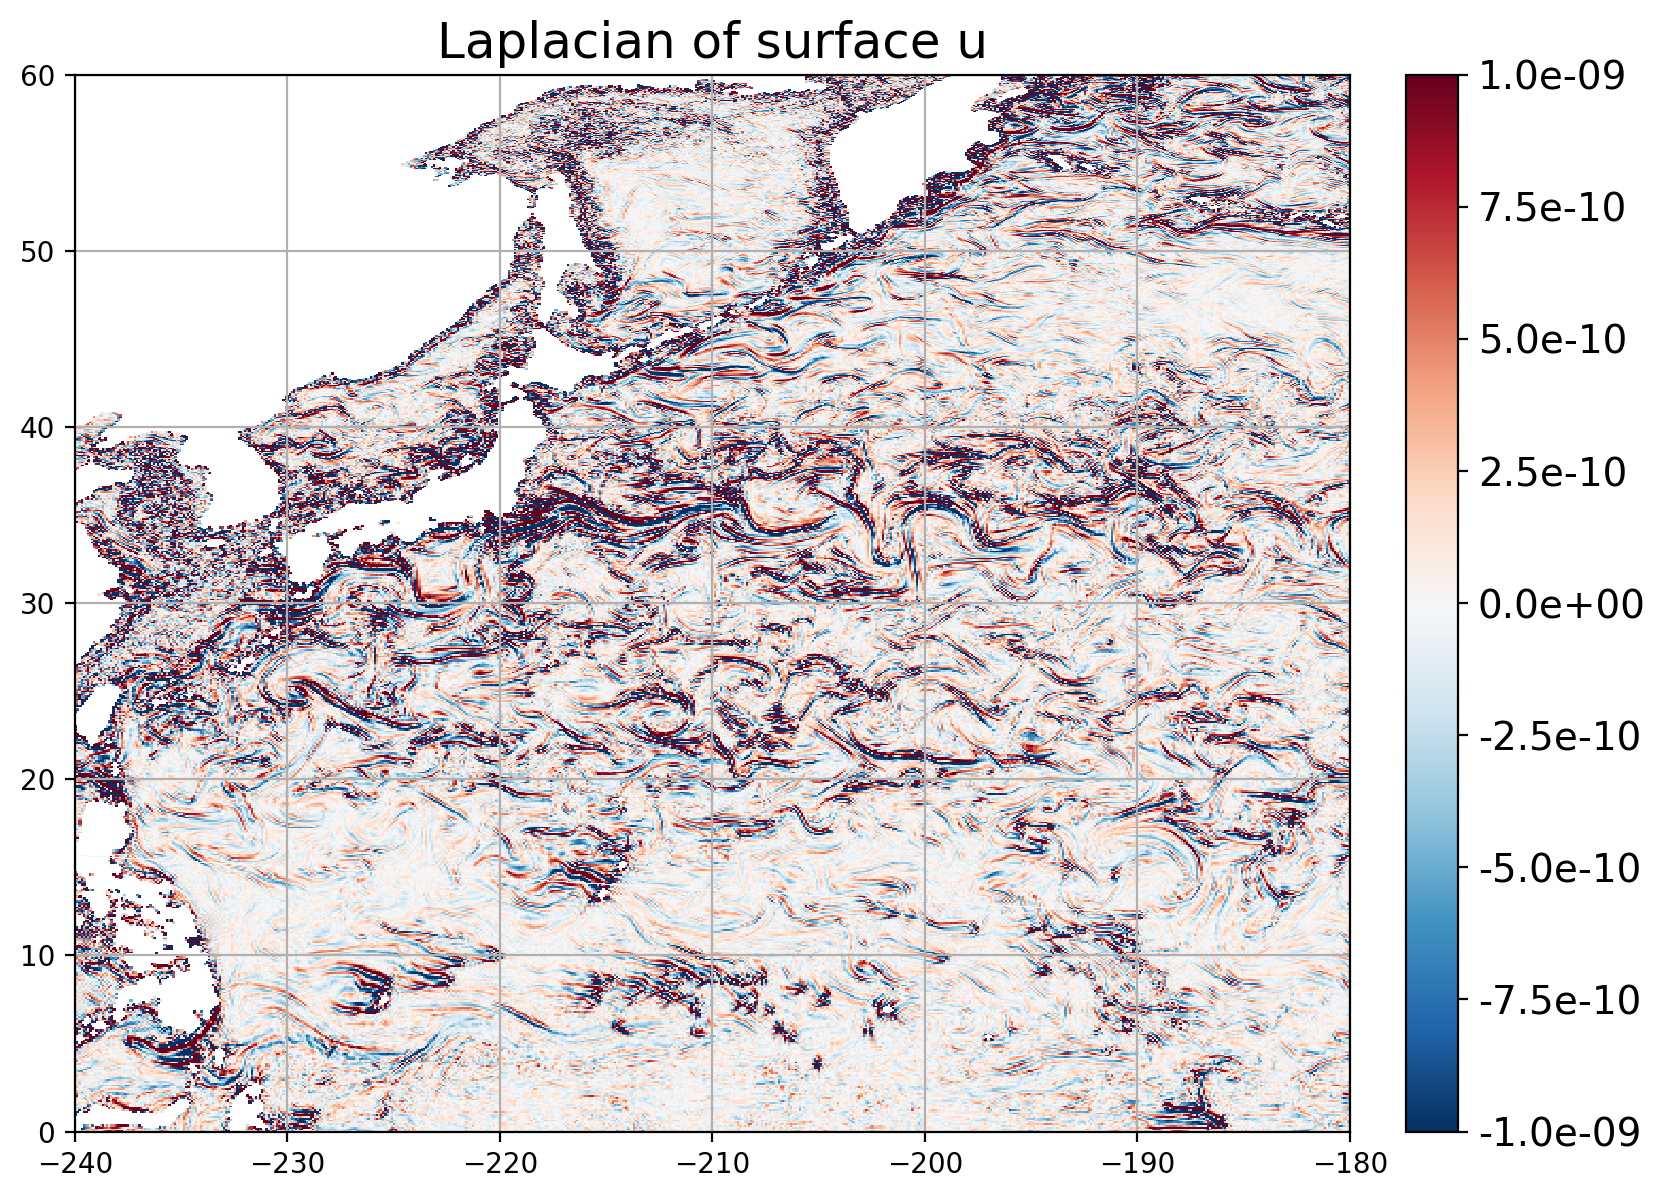

In [12]:
fig = plt.figure(figsize=(9, 7), dpi= 200, facecolor='w', edgecolor='k')

plt.pcolormesh(geolon,geolat,u_laplacian,cmap='RdBu_r',vmin=-1e-9,vmax=1e-9);
cbar=plt.colorbar(fraction=0.046, pad=0.04,format='%.1e'); cbar.ax.tick_params(labelsize=14);

#To isolate the western Pacific box uncomment this:
plt.xlim([-240,-180]); plt.ylim([0,60])
plt.grid('on')
plt.title('Laplacian of surface u',fontsize=18)
plt.show()

### Plotting the Laplacian of surface v-velocity

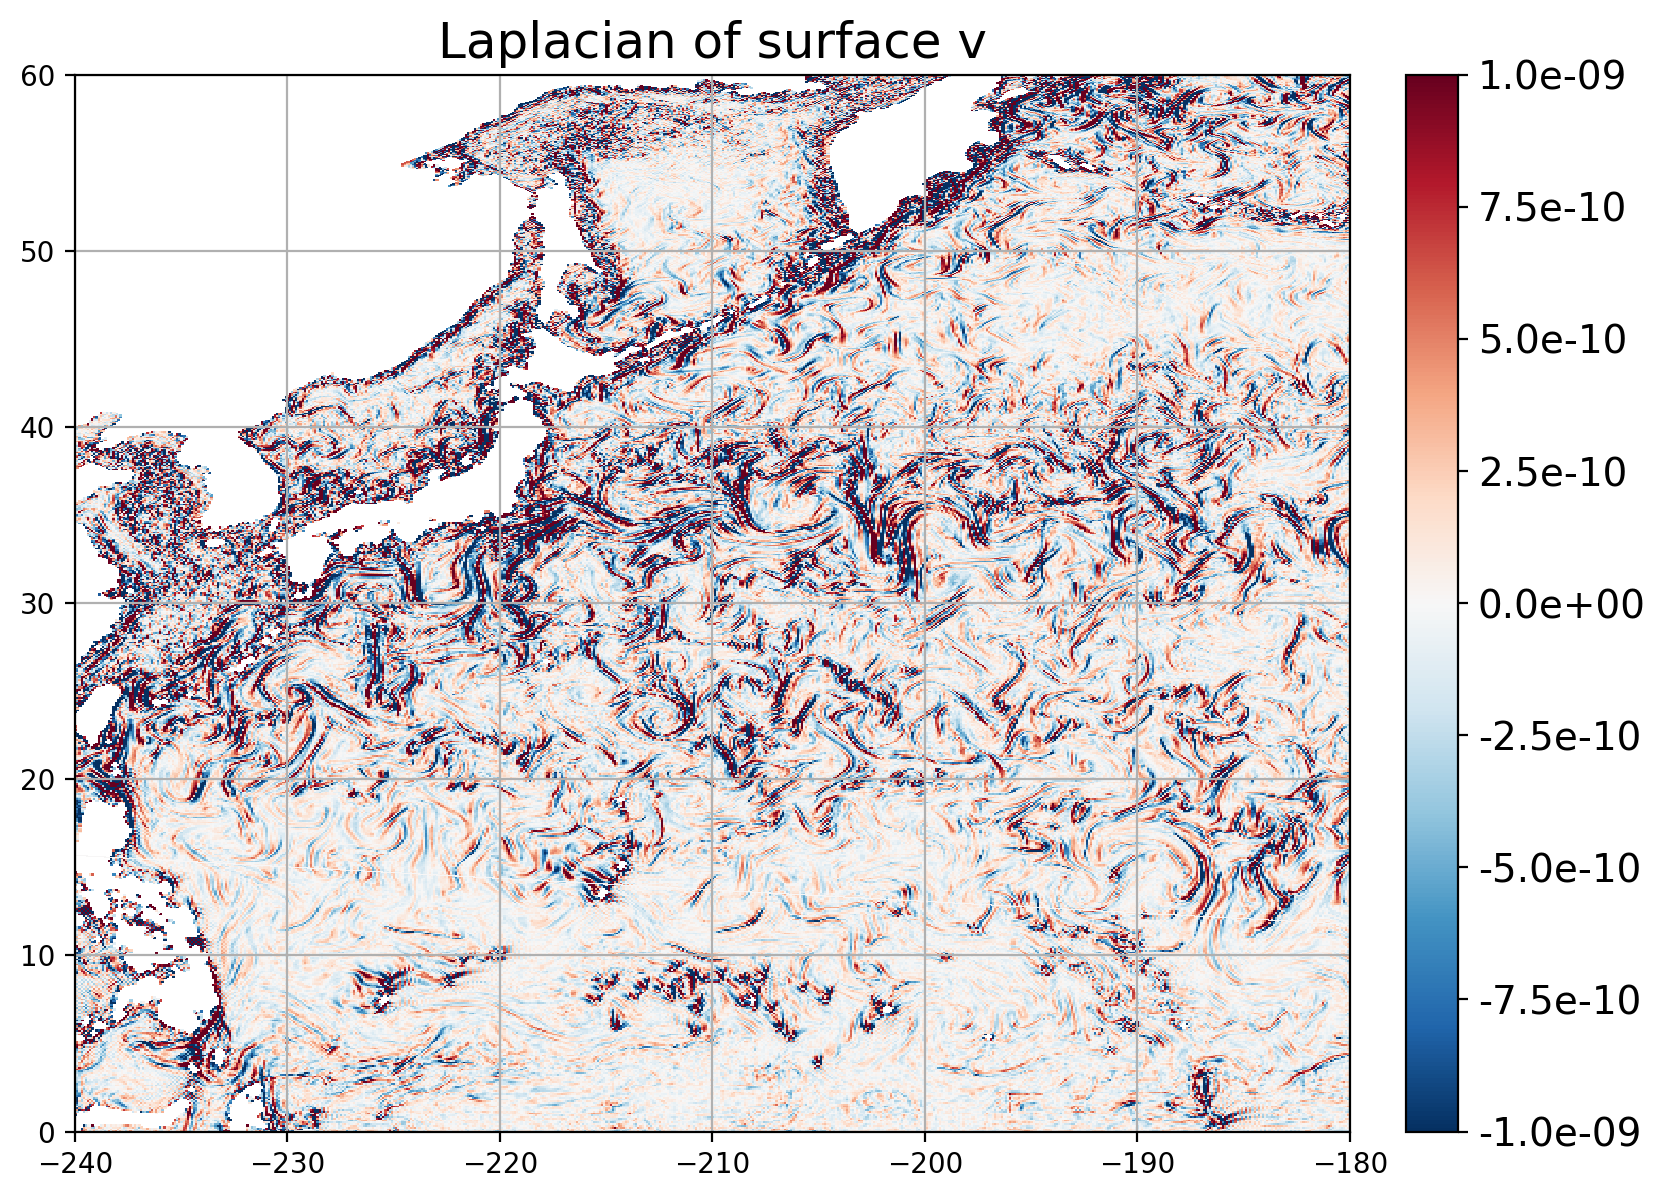

In [13]:
fig = plt.figure(figsize=(9, 7), dpi= 200, facecolor='w', edgecolor='k')

plt.pcolormesh(geolon,geolat,v_laplacian,cmap='RdBu_r',vmin=-1e-9,vmax=1e-9);
cbar=plt.colorbar(fraction=0.046, pad=0.04,format='%.1e'); cbar.ax.tick_params(labelsize=14);

#To isolate the western Pacific box uncomment this:
plt.xlim([-240,-180]); plt.ylim([0,60])
plt.grid('on')

plt.title('Laplacian of surface v',fontsize=18) #positive into ocean
plt.show()

### Defining the vorticity operator. The vorticity values are defined at t-points so that the MOM5 Laplacian defined at t-points should be employed on the vorticity field.

    vorticity_z(i,j) = 0.5*(
     (v(i,j) - v(i-1,j) )*Grd%dxtnr(i,j) +(v(i,j-1) - v(i-1,j-1))*Grd%dxtnr(i,j-1) &
    -(u(i,j) - u(i,j-1) )*Grd%dyter(i,j) -(u(i-1,j) - u(i-1,j-1))*Grd%dyter(i-1,j)
    ) 

In [14]:
def MOM5_vorticity(u, v, dxt, dyt):
    #u is the zonal velocity component (x-direction)
    #v is the meridional velocity component (y-direction)
    #dxt is x-direction grid spacing for a t-cell
    #dyt is y-direction grid spacing for a t-cell

    vorticity = np.empty(u.shape)
    
    for i in range(1,vorticity.shape[0]-1):
        for j in range(1,vorticity.shape[1]-1):
            dvdx=0.5*((v[i,j]-v[i-1,j])/(0.5*(dxt[i,j]+dxt[i,j+1])) + (v[i,j-1]-v[i-1,j-1])/(0.5*(dxt[i,j]+dxt[i,j-1])))
            dudy=0.5*((u[i,j]-u[i,j-1])/(0.5*(dyt[i,j]+dyt[i+1,j])) + (u[i-1,j]-u[i-1,j-1])/(0.5*(dyt[i,j]+dyt[i-1,j])))
            vorticity[i,j] = dvdx-dudy
    print('Computed vorticity')

    return vorticity

In [15]:
vorticity = MOM5_vorticity(usurf, vsurf, dxt, dyt)
vorticity_laplacian=MOM5_Laplacian_t(vorticity, dxt, dyt, dxu, dyu, dat)

Computed vorticity
Computed fx
Computed fy
Computed LAP_T


In [16]:
np.nanmean(vorticity_laplacian)

3.1973842254007843e-17

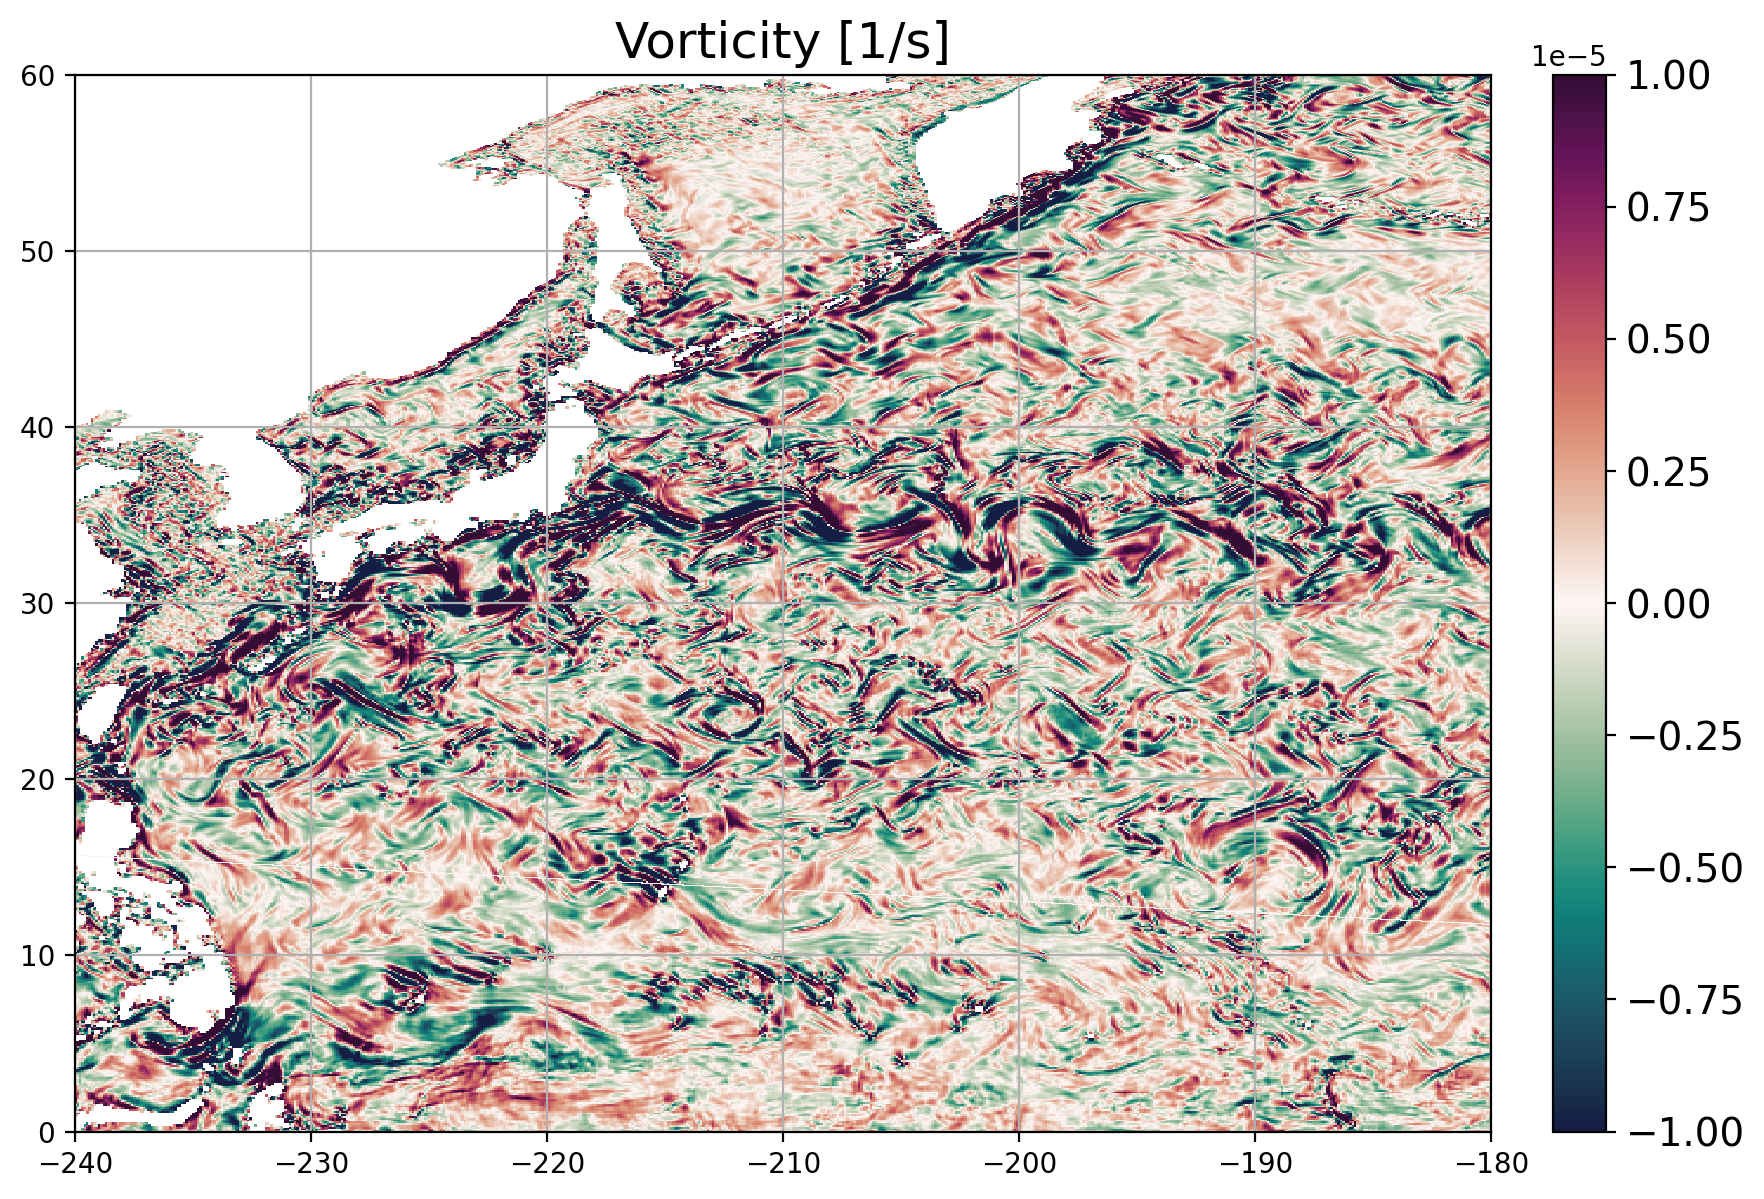

In [19]:
fig = plt.figure(figsize=(10, 7), dpi= 200, facecolor='w', edgecolor='k')

plt.pcolormesh(geolon,geolat,vorticity,cmap=cmocean.cm.curl,vmin=-1e-5,vmax=1e-5);
cbar=plt.colorbar(fraction=0.046, pad=0.04,format='%.1e'); cbar.ax.tick_params(labelsize=14);

#To isolate the western Pacific box uncomment this:
plt.xlim([-240,-180]); plt.ylim([0,60])
plt.grid('on')

plt.title('Vorticity [1/s]',fontsize=18) #positive into ocean
plt.show()

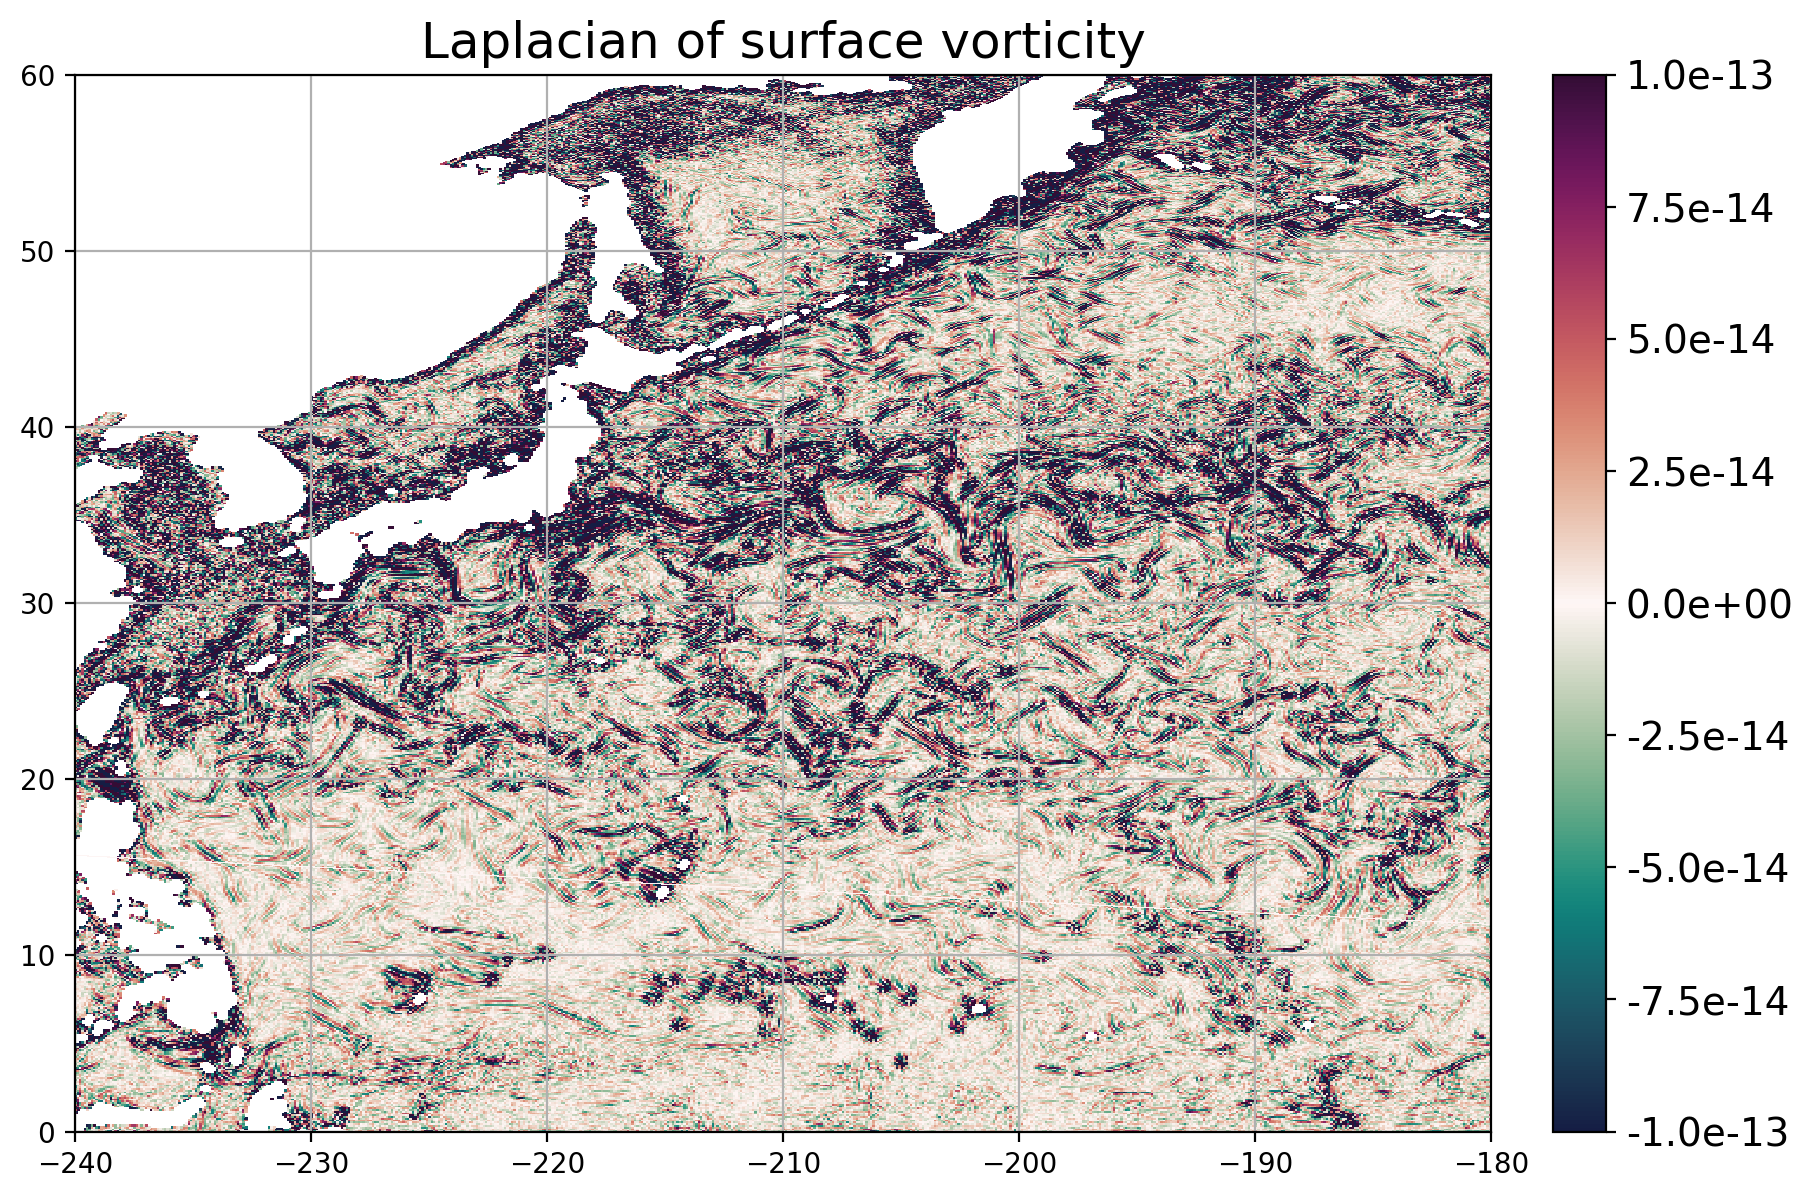

In [18]:
fig = plt.figure(figsize=(10, 7), dpi= 200, facecolor='w', edgecolor='k')

plt.pcolormesh(geolon,geolat,vorticity_laplacian,cmap=cmocean.cm.curl,vmin=-1e-13,vmax=1e-13);
cbar=plt.colorbar(fraction=0.046, pad=0.04,format='%.1e'); cbar.ax.tick_params(labelsize=14);

#To isolate the western Pacific box:
plt.xlim([-240,-180]); plt.ylim([0,60])
plt.grid('on')

plt.title('Laplacian of surface vorticity',fontsize=18) #positive into ocean
plt.show()

In [43]:
print('finished')

finished
